In [1]:
import EoN
import numpy as np
import pandas as pd
import networkx as nx
from collections import defaultdict
import random

import matplotlib.pyplot as plt
import scipy.sparse as sps
import seaborn as sns

from tqdm.autonotebook import tqdm
import time

plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

/Users/agarbuno/anaconda2/envs/risknet/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


In [2]:
import sys
sys.path.append('/Users/agarbuno/github-repos/collaborations/covid/risk-networks/risknet')

In [3]:
%load_ext autoreload
%autoreload 2
import epimodels
import ensemble
import epitools

In [4]:
# Load city-like network
net_size = '1e3'
edge_list = np.loadtxt('../data/networks/edge_list_SBM_%s.txt'%net_size, usecols = [0,1], dtype = int, skiprows = 1) 
G = nx.Graph([tuple(k) for k in edge_list])
G = nx.relabel_nodes(G, dict(zip(list(G.nodes()), range(len(G)))))
N = len(G)

In [5]:
# Set city label
city_classes = ['hospital', 'healthcare', 'city']
city_classes_range = [range(int(float(net_size) * 0.005)), 
                 range(int(float(net_size) * 0.005), int(float(net_size) * 0.045)), 
                 range(int(float(net_size) * 0.045), N)]

cohort = defaultdict()
for node in tqdm(G.nodes):
    if node in city_classes_range[0]:
        cohort[node] = {'cohort': city_classes[0]}
    elif node in city_classes_range[1]:
        cohort[node] = {'cohort': city_classes[1]}
    else:
        cohort[node] = {'cohort': city_classes[2]}
        
nx.set_node_attributes(G, cohort)

In [6]:
# latent period distribution: E -> I (σ)
l_mean = 2 + 1.7 * 2
# infectiousness duration outside hospitals: I -> . (γ)
g_mean = 1 + 1.5 * 2
# infectiousness duration in hospitals: H -> . (γ')
gp_mean = 1 + 1.5 * 3


# age structure King County, WA: https://datausa.io/profile/geo/king-county-wa#demographics
# we use the age classes: 0--19, 20--44, 45--64, 65--74, >= 75
age_classes = np.asarray([0.2298112587,0.3876994201,0.2504385036,0.079450985,0.0525998326])

# age distribution in working population: 20--44 and 45--64
age_classes_working = np.asarray([0.3876994201,0.2504385036])/sum([0.3876994201,0.2504385036])

# age-dependent hospitalization and recovery rates

fh = np.asarray([0.02, 0.17, 0.25, 0.35, 0.45])
fd = np.asarray([1e-15, 0.001, 0.005, 0.02, 0.05])
fdp = np.asarray([1e-15, 0.001, 0.01, 0.04, 0.1])

# hospitalization fraction (a...age class integers to refer to 0--19, 20--44, 45--64, 65--74, >= 75)

h_mean = lambda a: fh[a]
d_mean = lambda a: fd[a]
dp_mean = lambda a: fdp[a]

# transmission

beta0 = 0.05
betap0 = 0.75*beta0


In [7]:
attrs_dict = defaultdict()
np.random.seed(1)

for kk, node in tqdm(enumerate(list(G.nodes())), desc = 'Building properties'):
    age_group = np.random.choice(len(age_classes), p = age_classes)

    attrs = {
        'age_group': age_group
    }
    
    attrs_dict[node] = attrs
    
nx.set_node_attributes(G, attrs_dict)

In [8]:
Gstar = G.copy()
M = 100

In [9]:
Gs = list()

for mm in tqdm(range(M), 'List of graphs'):
    Gmm = Gstar.copy()
    np.random.seed(mm)
    attrs_dict = defaultdict()
    
    for kk, node in enumerate(list(Gstar.nodes())):
        
        cohort = Gstar.nodes[node]['cohort']
        age_group = Gstar.nodes[node]['age_group']

        g_samp    = 1/g_mean
        gp_samp   = 1/gp_mean
        h_samp    = h_mean(age_group)
        d_samp    = d_mean(age_group)
        dp_samp   = dp_mean(age_group)

        attrs = {
            'node'     : node, 
            'cohort'   : cohort,
            'age_group': age_group,
            'sigma'    : 1/l_mean,
            'gamma'    : g_samp,
            'gammap'   : gp_samp,
            'theta'    : (1 - h_samp - d_samp) * g_samp,
            'delta'    : h_samp * g_samp,
            'mu'       : d_samp * g_samp,
            'thetap'   : (1 - dp_samp) * gp_samp,
            'mup'      : dp_samp * gp_samp
        }
    
        attrs_dict[node] = attrs
        
    nx.set_node_attributes(Gmm, attrs_dict)
    Gs.append(Gmm)
    

In [10]:
ens = ensemble.epiens(M, Gs, N)
np.random.seed(1)
ens.init(beta = 0.06, hom = False)

In [11]:
for member in ens.ensemble:
    infected = np.random.choice(N, replace = False, size = int(N * 0.01))
    member.infected = infected
    member.init_infected(infected)

In [12]:
sims  = []

return_statuses = ('S', 'E', 'I', 'H', 'R', 'D')

for mm, member in tqdm(enumerate(ens.ensemble), desc = 'Simulations', total = M):
    sim = member.simulate(return_statuses)
    sims.append(sim)

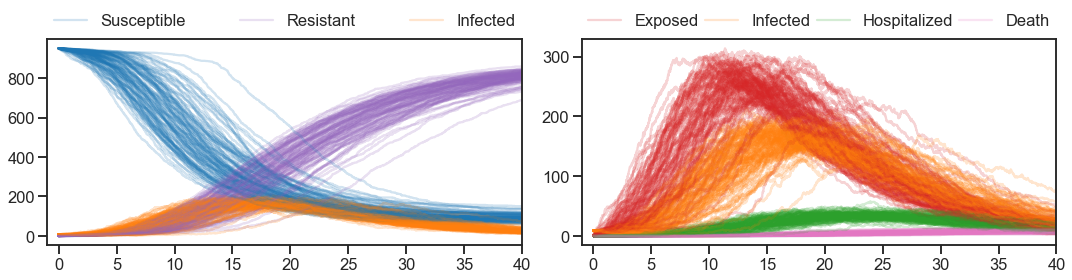

In [13]:
axes = epitools.plot_eon_simulations(sims, alpha = .2)

In [14]:
times_plot = [5, 10, 15, 40]
df = epitools.eon_sims_to_pandas(ens, sims, times_plot = times_plot)

In [15]:
ylims = [np.empty(2,), np.empty(2,)]
ylims[0] = axes[0].get_ylim()
ylims[1] = axes[1].get_ylim()

In [16]:
y0 = np.zeros([M, 5 * N])

for mm, member in enumerate(ens.ensemble):
    E, I, H, R, D = np.zeros([5, N])
    S = np.ones(N,)
    I[member.infected] = 1.
    S[member.infected] = 0.
    
    y0[mm, : ] = np.hstack((S, I, H, R, D))

In [17]:
T = 40.
t = np.linspace(0,T,201)
ens.set_solver(T = T, dt = np.diff(t).min(), reduced = True)      

In [18]:
start_time = time.time()

ke_euler = ens.ens_solve_euler(y0, t)
elapsed_time = time.time() - start_time

tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:28


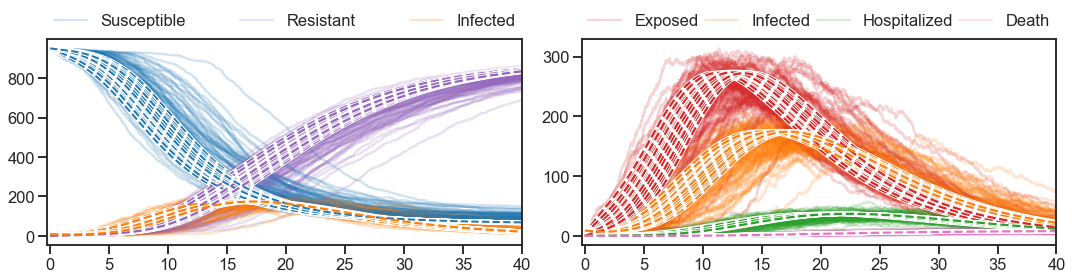

In [19]:
epitools.plot_eon_ode(sims, ke_euler, t, alpha = .2)

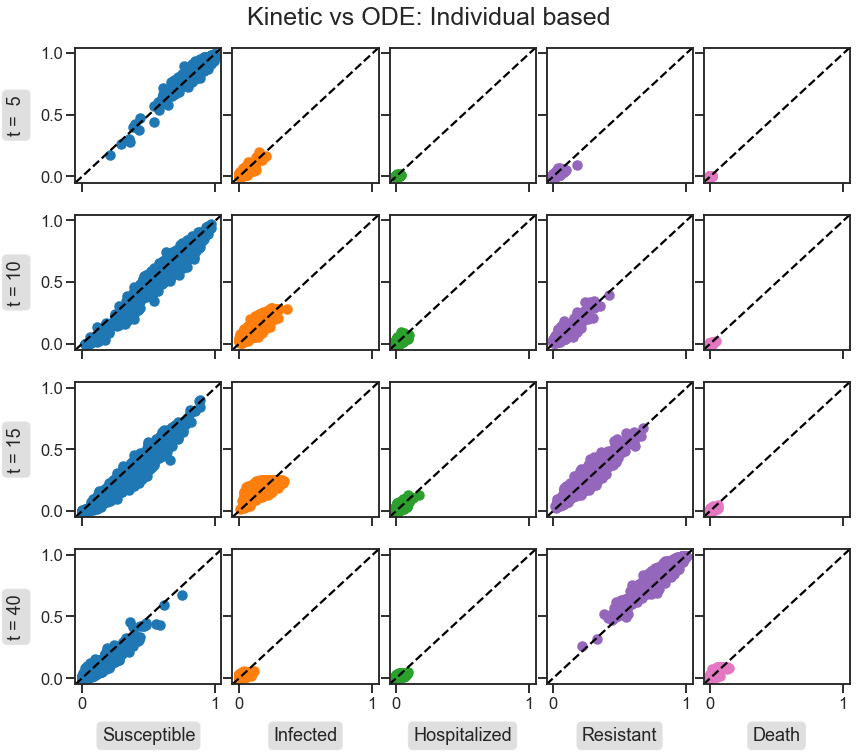

In [20]:
fig, axes = epitools.plot_node_probabilities(df, ke_euler, t)

plt.suptitle(r'Kinetic vs ODE: Individual based', y = 1.04, fontsize = 25)

files_directory = '/Users/agarbuno/github-repos/collaborations/covid/risk-networks/notebooks/imgs/'
file = 'kMC-ode-indv-probs-c01'
plt.savefig(files_directory+file+'.png', dpi=150)


### **Case 3.** This solves the whole system with simple Euler steps, now with the pair-based covariance closure. 

In [21]:
np.random.seed(1)

start_time = time.time()

ke_euler = ens.ens_solve_euler(y0, t, closure = 'covariance')

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:31


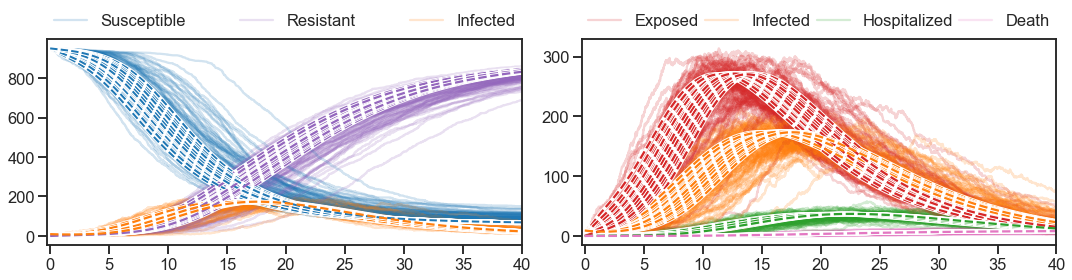

In [22]:
epitools.plot_eon_ode(sims, ke_euler, t, alpha = .2)

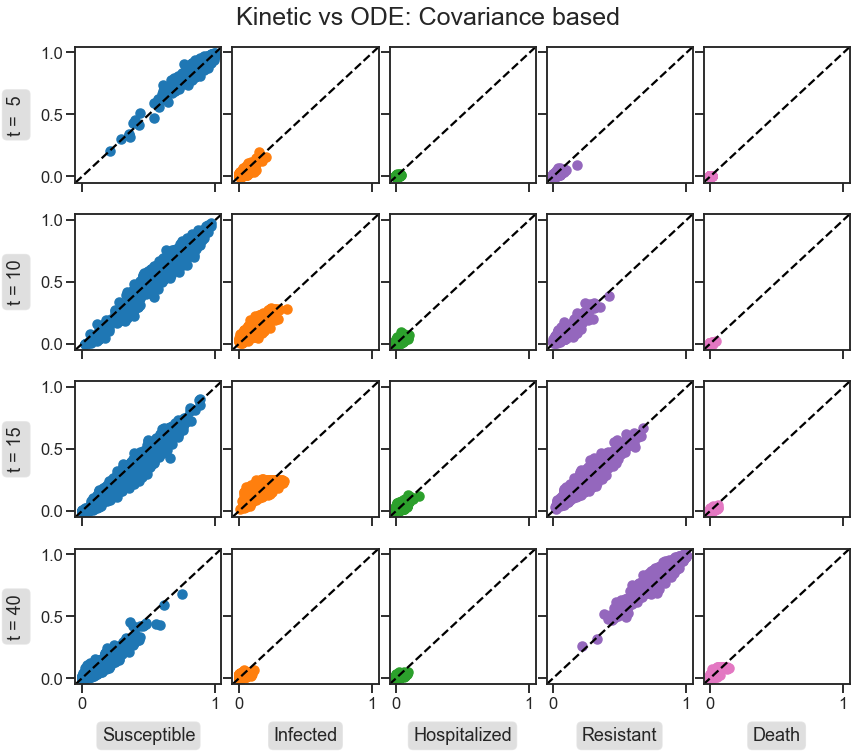

In [23]:
fig, axes = epitools.plot_node_probabilities(df, ke_euler, t)
    
plt.suptitle(r'Kinetic vs ODE: Covariance based', y = 1.04, fontsize = 25)
fig.tight_layout(h_pad = 2.2, w_pad = .2)

files_directory = '/Users/agarbuno/github-repos/collaborations/covid/risk-networks/notebooks/imgs/'
file = 'kMC-ode-cov-probs-c01'
plt.savefig(files_directory+file+'.png', dpi=150)

### **Case 4.** This solves the whole system with simple Euler steps, now with the pair-based correlation closure. 

In [24]:
np.random.seed(1)

start_time = time.time()

ke_euler = ens.ens_solve_euler(y0, t, closure = 'correlation')

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:44


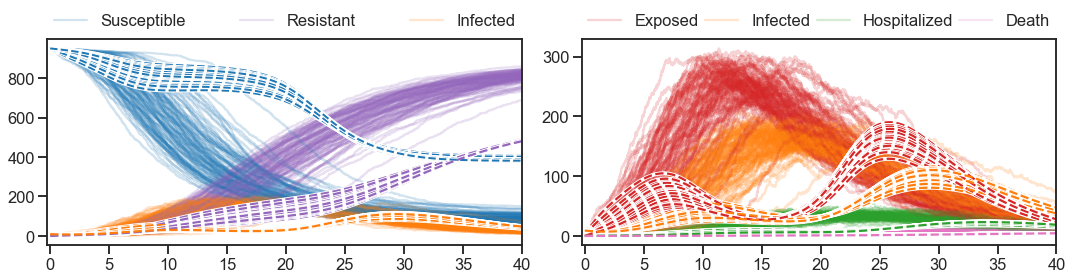

In [25]:
epitools.plot_eon_ode(sims, ke_euler, t, alpha = .2)

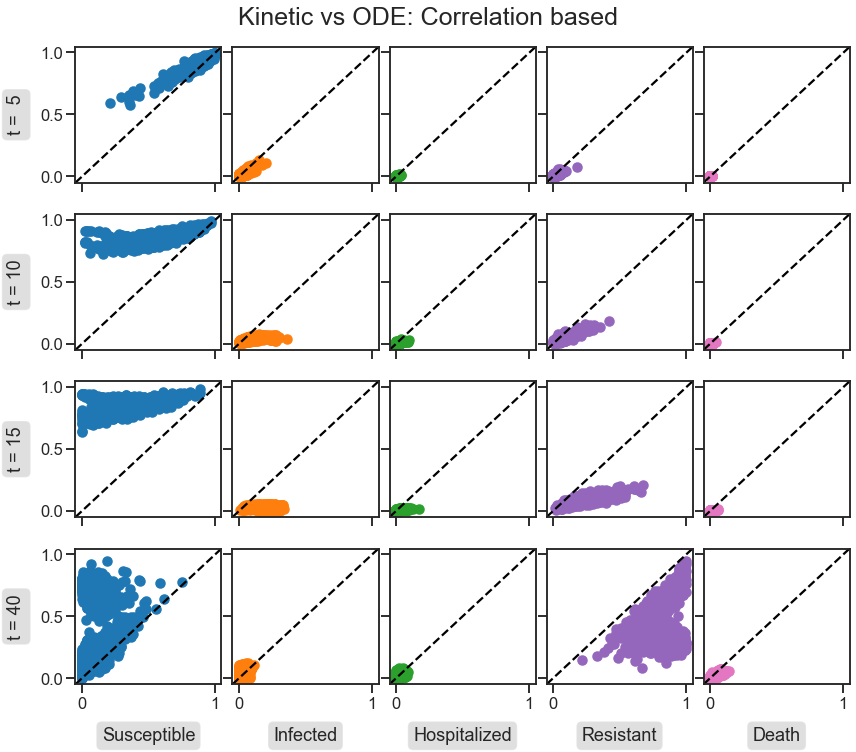

In [26]:
fig, axes = epitools.plot_node_probabilities(df, ke_euler, t)
    
plt.suptitle(r'Kinetic vs ODE: Correlation based', y = 1.04, fontsize = 25)
fig.tight_layout(h_pad = 2.2, w_pad = .2)

files_directory = '/Users/agarbuno/github-repos/collaborations/covid/risk-networks/notebooks/imgs/'
file = 'kMC-ode-corr-probs-c01'
plt.savefig(files_directory+file+'.png', dpi=150)